In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [2]:
# How to Train Boosted Trees Models in TF

In [3]:
# Boosted Trees models are popular with many ML practitioners
# as they can achieve impressive performance with minimal
# hyperparameter tuning.
# Load the Titanic dataset
from __future__ import absolute_import, division, \
    print_function, unicode_literals

In [4]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

/home/allisonrmcalister/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/home/allisonrmcalister/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216, got 192
  return f(*args, **kwds)
/home/allisonrmcalister/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/home/allisonrmcalister/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [5]:
tf.enable_eager_execution()

In [6]:
tf.logging.set_verbosity(tf.logging.ERROR)

In [7]:
tf.set_random_seed(123)

In [9]:
# Load dataset
dftrain = pd.read_csv(\
    'https://storage.googleapis.com/tfbt/titanic_train.csv')

In [10]:
dfeval = pd.read_csv(\
    'https://storage.googleapis.com/tfbt/titanic_eval.csv')

In [11]:
# Goal: Predict passenger survival given characteristics such
# as gender, age, class, etc.
y_train = dftrain.pop('survived')
y_eval = dfeval.pop('survived')

In [12]:
# Training - Use the following features:
# sex, age, n_siblings_spouses, parch (parents/children), 
# fare, class, deck, embark_town, alone

In [13]:
# Explore the data
dftrain.head()

,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone
0,male,22.0,1,0,7.2500,Third,unknown,Southampton,n
1,female,38.0,1,0,71.2833,First,C,Cherbourg,n
2,female,26.0,0,0,7.9250,Third,unknown,Southampton,y
3,female,35.0,1,0,53.1000,First,C,Southampton,n
4,male,28.0,0,0,8.4583,Third,unknown,Queenstown,y


In [14]:
dftrain.describe()

,age,n_siblings_spouses,parch,fare
count,627.000000,627.000000,627.000000,627.000000
mean,29.631308,0.545455,0.379585,34.385399
std,12.511818,1.151090,0.792999,54.597730
min,0.750000,0.000000,0.000000,0.000000
25%,23.000000,0.000000,0.000000,7.895800
50%,28.000000,0.000000,0.000000,15.045800
75%,35.000000,1.000000,0.000000,31.387500
max,80.000000,8.000000,5.000000,512.329200


In [15]:
dftrain.shape, dfeval.shape

((627, 9), (264, 9))

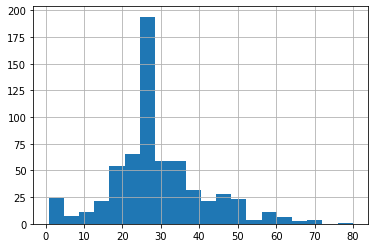

In [16]:
# Majority of the passengers are in their 20s and 30s
dftrain.age.hist(bins=20)
plt.show()

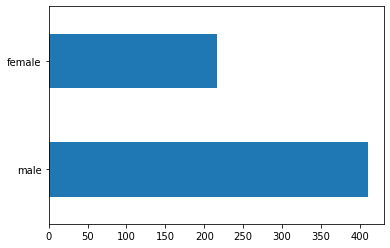

In [17]:
# Approx 2x as many male passengers as female passengers
dftrain.sex.value_counts().plot(kind='barh')

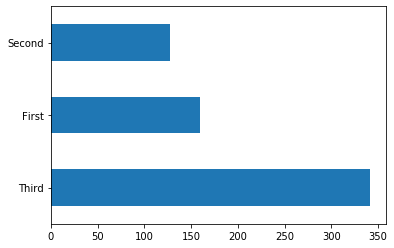

In [18]:
# Majority of passengers were in "third" class
dftrain['class'].value_counts().plot(kind='barh')

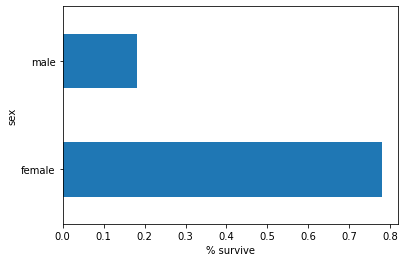

In [19]:
# Females have a higher chance of surviving vs. males.
ax = (pd.concat([dftrain, y_train], axis=1)\
     .groupby('sex').survived.mean().plot(kind='barh'))
ax.set_xlabel('% survive')
plt.show()

In [20]:
# Create feature columns and input functions
# Gradient Boosting estimator can utilize both 
# numeric and categorical features. Categorical columns are 
# transformed to one-hot-encoded columns.
fc = tf.feature_column
CATEGORICAL_COLUMNS = ['sex', 'n_siblings_spouses', 'parch', \
                      'class', 'deck', 'embark_town', 'alone']
NUMERIC_COLUMNS = ['age', 'fare']

In [21]:
def one_hot_cat_column(feature_name, vocab):
    return fc.indicator_column(\
                fc.categorical_column_with_vocabulary_list(\
                    feature_name, vocab))

In [22]:
feature_columns = []

In [23]:
for feature_name in CATEGORICAL_COLUMNS:
    # One-hot encode categorical features
    vocabulary = dftrain[feature_name].unique()
    feature_columns.append(one_hot_cat_column(feature_name,\
                                    vocabulary))

In [25]:
for feature_name in NUMERIC_COLUMNS:
    feature_columns.append(fc.numeric_column(feature_name, \
                                    dtype=tf.float32))

In [26]:
# Can view the transformation produced by a feature column.
example = dftrain.head(1)

In [27]:
example

,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone
0,male,22.0,1,0,7.25,Third,unknown,Southampton,n


In [28]:
class_fc = one_hot_cat_column('class', \
                ('First', 'Second','Third'))

In [29]:
print('Feature value: "{}"'.format(example['class'].iloc[0]))

Feature value: "Third"


In [30]:
print('One-hot encoded: ', fc.input_layer(dict(example), \
                                [class_fc]).numpy())

One-hot encoded:  [[0. 0. 1.]]


In [31]:
# Can view all of the feature column transformations together
fc.input_layer(dict(example), feature_columns).numpy()

array([[22.  ,  1.  ,  0.  ,  1.  ,  0.  ,  0.  ,  1.  ,  0.  ,  0.  ,
         0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  1.  ,  0.  ,  0.  ,  0.  ,
         7.25,  1.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  1.  ,
         0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  1.  ,  0.  ]], dtype=float32)

In [32]:
# Create the input functions. These specify how data will be 
# read into the model for training and inference.
# Use tf.data.from_tensor_slices to read in data directly from 
# pandas. This is suitable for smaller, in-memory datasets.
# For larger datasets, a variety of file formats are supported,
# including CSV.

In [33]:
NUM_EXAMPLES = len(y_train)

In [34]:
def make_input_fn(X, y, n_epochs=None, shuffle=True):
    y = np.expand_dims(y, axis=1)
    def input_fn():
        dataset = tf.data.Dataset.from_tensor_slices((dict(X),y))
        if shuffle:
            dataset = dataset.shuffle(NUM_EXAMPLES)
        # For training, cycle through dataset n_epochs times
        dataset = dataset.repeat(n_epochs)
        # In memory training doesn't use batching
        dataset = dataset.batch(NUM_EXAMPLES)
        return dataset
    return input_fn

In [35]:
# training and evaluation input functions
train_input_fn = make_input_fn(dftrain, y_train)
eval_input_fn = make_input_fn(dfeval, y_eval, \
                        shuffle=False,n_epochs=1)

In [36]:
# Initialize model, specifying features and hyperparameters
linear_est = tf.estimator.LinearClassifier(feature_columns)

In [37]:
# Train model
linear_est.train(train_input_fn, max_steps=100)

In [38]:
# Evaluation
results = linear_est.evaluate(eval_input_fn)

In [39]:
print('Accuracy: ', results['accuracy'])
print('Dummy model: ', results['accuracy_baseline'])

Accuracy:  0.78409094
Dummy model:  0.625


In [40]:
# Train a Boosted trees model. 
# Regression: BoostedTreesRegressor
# Classification: BoostedTreesClassifier
# Twice differentiable custom loss: BoostedTreesEstimator
n_batches = 1
est = tf.estimator.BoostedTreesClassifier(feature_columns, \
                        n_batches_per_layer=n_batches)

In [41]:
# The model will stop training once the specified number of trees
# is build, not based on the number of steps.
est.train(train_input_fn, max_steps=100)

In [42]:
# Evaluate
results = est.evaluate(eval_input_fn)

In [43]:
print('Accuracy: ', results['accuracy'])
print('Dummy model: ', results['accuracy_baseline'])

Accuracy:  0.8181818
Dummy model:  0.625


In [44]:
# Performance reasons: when your data fits in memory, it is
# recommended to use the boosted_trees_classifier_train_in_memory
# function. If training time is not of concenr, or if the dataset
# is large and you want to do distributed training, use the
# tf.estimator.BoostedTrees API from above.

In [45]:
# When using this method, don't batch input data. This method
# operates on the entire dataset.
def make_inmemory_train_input_fn(X,y):
    y = np.expand_dims(y, axis=1)
    def input_fn():
        return dict(X), y
    return input_fn

In [46]:
train_input_fn = make_inmemory_train_input_fn(dftrain, y_train)

In [47]:
eval_input_fn = make_input_fn(dfeval, y_eval, shuffle=False,\
                             n_epochs=1)

In [48]:
est = tf.contrib.estimator.\
    boosted_trees_classifier_train_in_memory(\
            train_input_fn, feature_columns)

/home/allisonrmcalister/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/home/allisonrmcalister/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/home/allisonrmcalister/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/home/allisonrmcalister/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [49]:
print(est.evaluate(eval_input_fn)['accuracy'])

0.7916667


In [50]:
# Make predictions on a passenger from the evaluation set.
pred_dicts = list(est.predict(eval_input_fn))

In [51]:
pred_dicts

[{'logits': array([-5.6187835], dtype=float32),
  'logistic': array([0.00361589], dtype=float32),
  'probabilities': array([0.996384  , 0.00361593], dtype=float32),
  'class_ids': array([0]),
  'classes': array([b'0'], dtype=object),
  'all_class_ids': array([0, 1], dtype=int32),
  'all_classes': array([b'0', b'1'], dtype=object)},
 {'logits': array([-0.9413828], dtype=float32),
  'logistic': array([0.2806211], dtype=float32),
  'probabilities': array([0.7193789, 0.2806211], dtype=float32),
  'class_ids': array([0]),
  'classes': array([b'0'], dtype=object),
  'all_class_ids': array([0, 1], dtype=int32),
  'all_classes': array([b'0', b'1'], dtype=object)},
 {'logits': array([-2.5465376], dtype=float32),
  'logistic': array([0.0726594], dtype=float32),
  'probabilities': array([0.92734057, 0.07265943], dtype=float32),
  'class_ids': array([0]),
  'classes': array([b'0'], dtype=object),
  'all_class_ids': array([0, 1], dtype=int32),
  'all_classes': array([b'0', b'1'], dtype=object)},
 {

In [52]:
probs = pd.Series([pred['probabilities'][1] \
                       for pred in pred_dicts])

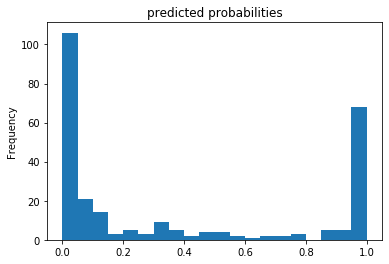

In [53]:
probs.plot(kind='hist', bins=20, title='predicted probabilities')

In [54]:
# Look at receiver operating characteristic (ROC)
from sklearn.metrics import roc_curve

In [55]:
fpr, tpr, _ = roc_curve(y_eval, probs)

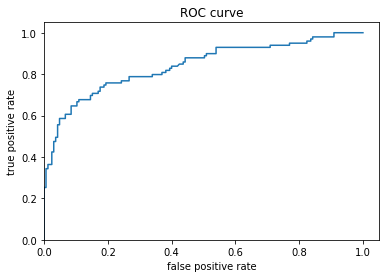

In [56]:
plt.plot(fpr, tpr)
plt.title('ROC curve')
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.xlim(0,)
plt.ylim(0,)
plt.show()